In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_absolute_error, median_absolute_error, mean_squared_error,
    r2_score, explained_variance_score, mean_absolute_percentage_error
)


               Year  average_rain_fall_mm_per_year  pesticides_tonnes  \
count  28242.000000                    28242.00000       28242.000000   
mean    2001.544296                     1149.05598       37076.909344   
std        7.051905                      709.81215       59958.784665   
min     1990.000000                       51.00000           0.040000   
25%     1995.000000                      593.00000        1702.000000   
50%     2001.000000                     1083.00000       17529.440000   
75%     2008.000000                     1668.00000       48687.880000   
max     2013.000000                     3240.00000      367778.000000   

           avg_temp    hg/ha_yield  
count  28242.000000   28242.000000  
mean      20.542627   77053.332094  
std        6.312051   84956.612897  
min        1.300000      50.000000  
25%       16.702500   19919.250000  
50%       21.510000   38295.000000  
75%       26.000000  104676.750000  
max       30.650000  501412.000000  


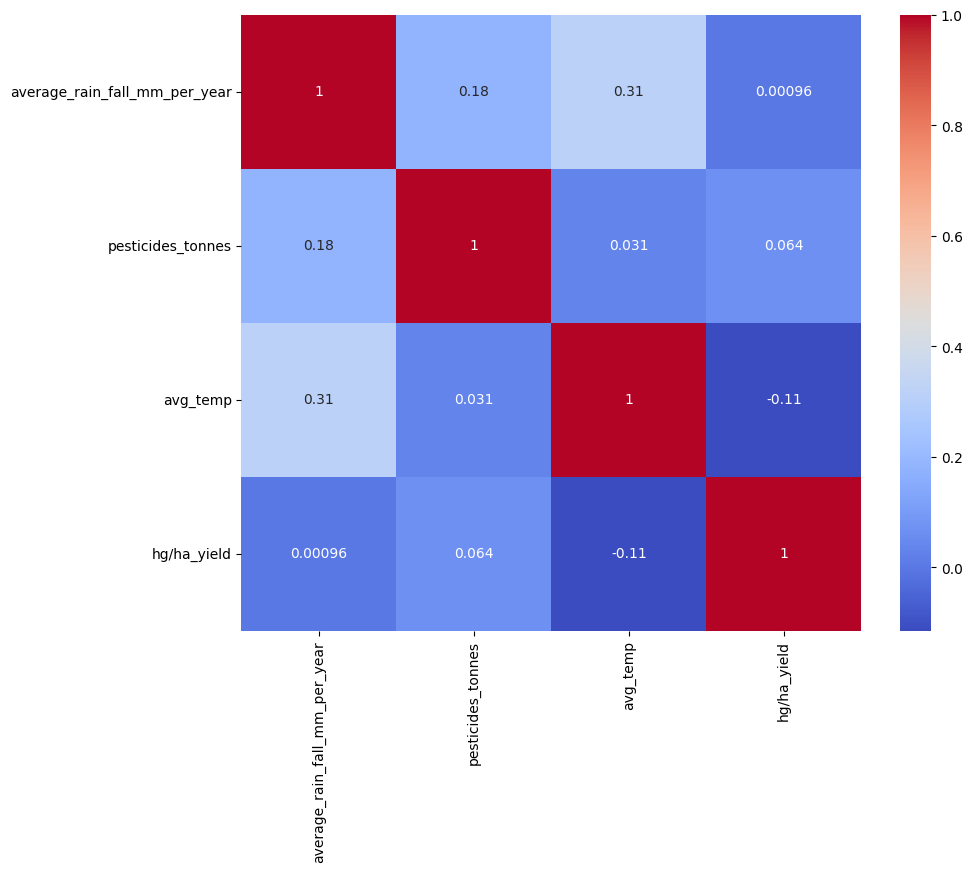

In [3]:
# Load the data
file_path = './climate_crop.csv'
data = pd.read_csv(file_path)

# Display basic statistics
print(data.describe())

# Plot correlation matrix
plt.figure(figsize=(10, 8))
data=data.drop(columns=['Item','Year','Area','Continent'],axis=1)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

# Selecting the relevant columns
features = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
target = 'hg/ha_yield'

# Handle any missing values if present
data = data.dropna()
#naem bro

# Separate the features and target
X = data[features]
y = data[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:



# Initialize the models
models = {
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

# Train the models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Evaluate the models
def evaluate_models(models, X_test, y_test):
    results = []
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        results.append({
            'Model': model_name,
            'MAE': mae,
            'MEDAE': medae,
            'MSE': mse,
            'RMSE': rmse,
            'Max Error': np.max(np.abs(y_test - y_pred)),
            'R2 Score': r2,
            'EVS': evs,
            'MAPE': mape
        })
    return pd.DataFrame(results)

# Evaluate the initial models
evaluation_results = evaluate_models(models, X_test, y_test)
print(evaluation_results)

# Fine-tune the best model (initially assuming Gradient Boosting, can be adjusted based on initial results)
param_grid_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train, y_train)
best_model_gb = grid_search_gb.best_estimator_

param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}
grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search_svr.fit(X_train, y_train)
best_model_svr = grid_search_svr.best_estimator_

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0]
}
grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_model_xgb = grid_search_xgb.best_estimator_

# Evaluate the best models
best_models = {
    'Best Gradient Boosting': best_model_gb,
    'Best SVR': best_model_svr,
    'Best XGBoost': best_model_xgb
}
best_evaluation_results = evaluate_models(best_models, X_test, y_test)
print(best_evaluation_results)

# Function to predict yield based on user input
def predict_yield(rainfall, pesticides, temp, model):
    # Standardize the input
    input_scaled = scaler.transform([[rainfall, pesticides, temp]])
    # Predict yield
    predicted_yield = model.predict(input_scaled)
    return predicted_yield[0]

# Example usage
rainfall = float(input("Enter average rainfall (mm per year): "))
pesticides = float(input("Enter pesticides (tonnes): "))
temp = float(input("Enter average temperature: "))
predicted_yield = predict_yield(rainfall, pesticides, temp, best_model_gb)  # Using best_model_gb as an example
print(f"Predicted yield (hg/ha) with Gradient Boosting: {predicted_yield}")

predicted_yield_svr = predict_yield(rainfall, pesticides, temp, best_model_svr)  # Using best_model_svr as an example
print(f"Predicted yield (hg/ha) with SVR: {predicted_yield_svr}")

predicted_yield_xgb = predict_yield(rainfall, pesticides, temp, best_model_xgb)  # Using best_model_xgb as an example
print(f"Predicted yield (hg/ha) with XGBoost: {predicted_yield_xgb}")

#run code naem
